<h1 align="center">Similarity-Based Classifier</h1> 

- MNIST dataset
- Simple classification measures
- Similarity-Based Classifer
- K Nearest Neighbors
- Отступ, эталонные объекты
- Custom Metrics
- Spaces, Dimension
- Implementation
- CIFAR10 Dataset

TODO: feature selection, metric learning

In [1]:
import time
import warnings
import datetime
import numpy as np
import pandas as pd
import random as rnd
import seaborn as sns
import IPython.core.display as ip
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, LSHForest

%pylab inline
%matplotlib inline

rnd.seed(16)
sns.set_style("white")
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<h1 align="center">MNIST dataset</h1> 

MNIST - известный dataset рукописных цифр, все цифры нормализованы, отцентрированы и имеют фиксированный размер. В MNIST представлено порядка 60000 объектов для обучения и 10000 объектов для контроля [http://yann.lecun.com/exdb/mnist/].

# Dataset

Загрузка данных

In [2]:
mnist = pd.read_csv('data/mnist.csv')

In [3]:
mnist[mnist.columns[:10]+mnist.columns[-4:]].head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel780,pixel781,pixel782,pixel783,pixel8
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
mnist.columns

Index([u'label', u'pixel0', u'pixel1', u'pixel2', u'pixel3', u'pixel4',
       u'pixel5', u'pixel6', u'pixel7', u'pixel8',
       ...
       u'pixel774', u'pixel775', u'pixel776', u'pixel777', u'pixel778',
       u'pixel779', u'pixel780', u'pixel781', u'pixel782', u'pixel783'],
      dtype='object', length=785)

Возьмем только подмножество, для того, чтобы тратить меньше времени на обработку

In [6]:
indices = numpy.random.permutation(mnist.shape[0])

mnist_train = mnist.ix[indices[:15000]]
Y_train = mnist_train['label'].values
X_train = mnist_train[mnist_train.columns[1:]].values

mnist_test = mnist.ix[indices[15000:20000]]
Y_test = mnist_test['label'].values
X_test = mnist_test[mnist_test.columns[1:]].values

Нарисуем примеры цифр из датасета

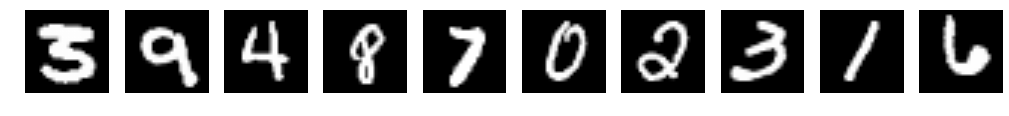

In [7]:
def plot_image(image_id, dataset=X_train, im_size=28):
    pylab.imshow(255-dataset[image_id,:].reshape(im_size, im_size))
    
def plot_grid(image_ids, nrows, ncols, dataset=X_train, im_size=28):
    fig = pyplot.gcf()
    fig.set_size_inches(17.5,15.5)
    for pylab_index, example_id in enumerate(image_ids):
        pylab.subplot(nrows, ncols, pylab_index + 1)
        plot_image(example_id, dataset, im_size)
        pylab.axis('off')
plot_grid(range(10), nrows=1, ncols=10)

Зачем распознавать рукописные символы? Автоматизация рутинной работы, проверка экзменов и т.п.
Распознавание печатных символов очень актуально для компьютерного зрения -- автомобили, камеры наблюдения и пр., широко применимо для людей с ограниченными возможностями. 

# Simplest Measure 

Будем решать задачу классификации, для неизвестного изображения предсказывать, какая цифра на нем изображена. 
Кажется, что чем больше цифр мы классифицируем правильно, тем лучше работает наш классификатор -- такая метрика 
качества называется точность (accuracy). 

## $$Accuracy = \frac{\sum_{x_i, y_i \in (X, Y)} I(y(x_i) = y_i)}{|(X, Y)|} = \frac{num~right~classified~obj}{num~all~obj}$$

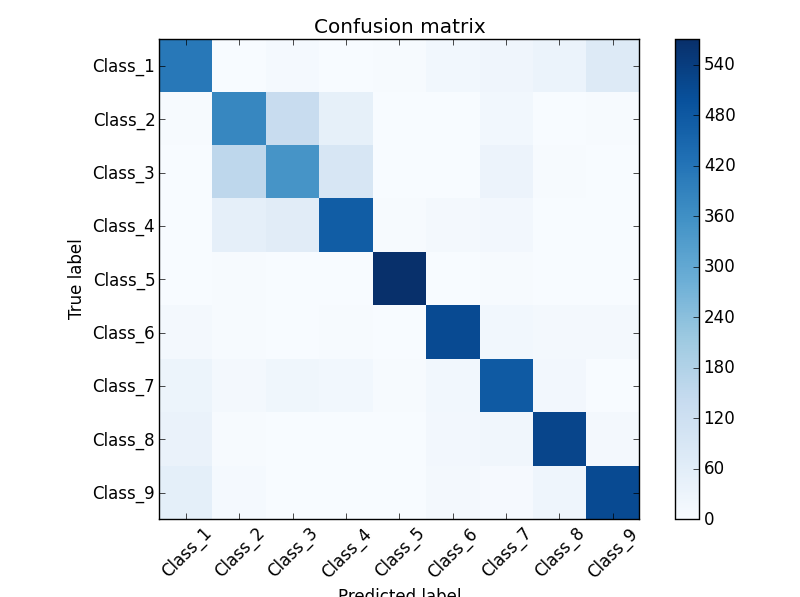

In [8]:
ip.Image('img/conf_mtx.png', width=600)

<h1 align="center">Similarity-Based Classifer</h1> 

Одна из самых простых идей -- для предсказания метки класса объекта x, найти близкие (похожие объекты) к объекту x. После чего, основываясь на соотношениях близких объектов можно предсказать к какому классу принадлежит элемент.

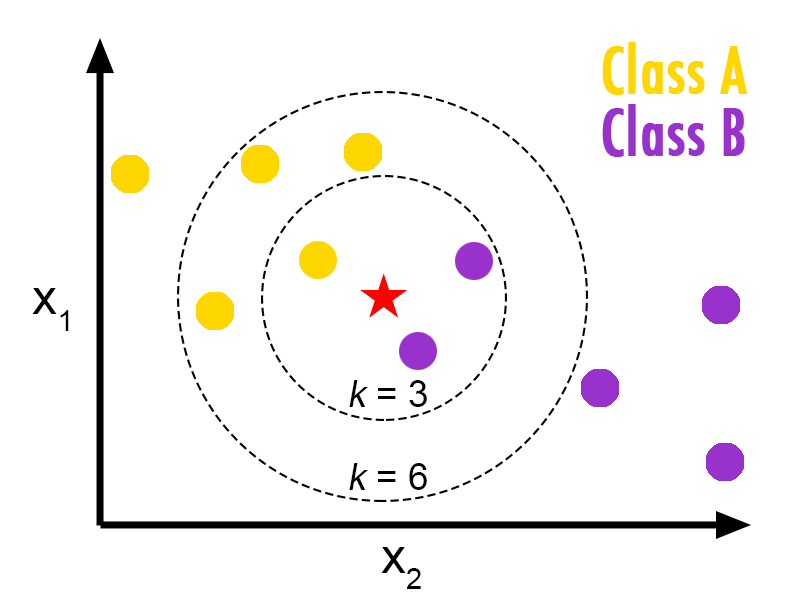

In [9]:
ip.Image('img/knn-concept.png')

# K Nearest Neighbors

Выразим эту идею в виде формулы.

## $$a(x, X^l) = \arg \max_{y \in Y} \sum_{i=1}^{l} [y^{(i)} = y]$$

### $(x^{(i)}, y^{(i)})$ - $i$-й сосед объекта x

In [11]:
def get_neighbors(example_img, X_minus_example, Y_minus_example, estimator):
    distances, indices = estimator.kneighbors(example_img, n_neighbors=10)
    distances, indices = distances[0], indices[0]
    
    df = pd.DataFrame()
    df['distances'], df['indices']  = distances, indices
    df['labels'] = Y_minus_example[indices]
    
    return df

Выберем случайный не очень хороший объект, и посмотрим на 5 ближайших соседей

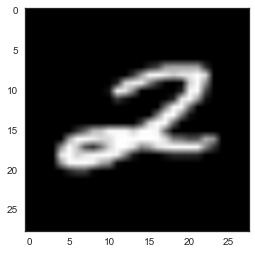

In [24]:
example_id = 400
plot_image(example_id)

In [25]:
estimator = KNeighborsClassifier().fit(X_train, Y_train)
get_neighbors(X_train[example_id], X_train, Y_train, estimator, )

,distances,indices,labels
0,0.000000,400,2
1,1445.871018,11219,2
2,1501.393686,6646,2
3,1557.203262,14165,2
4,1574.072108,8563,2
5,1574.452286,14455,2
6,1581.684545,2271,2
7,1589.698399,13940,2
8,1633.734985,13194,2
9,1644.203455,13758,3


Как предсказать вероятности классов при условии объекта?

In [26]:
prediction = estimator.predict_proba(X_train[example_id])
print ', '.join('y=%s: %.2f' % e for e in enumerate(prediction[0]) if e[1] != 0)

y=2: 1.00


## Отступ, эталонные объекты

Рассмотрим классификатор: 
## $$a: X \rightarrow Y $$

## $$a(x) = {\mathrm{argmax}} (\Gamma_y(x)), y \in Y, x \in X $$

Отступ: 
## $$M(x_i) = \Gamma_{y_i}(x_i) - \max_{y \in Y \setminus y_i} \Gamma_{y}(x_i) $$

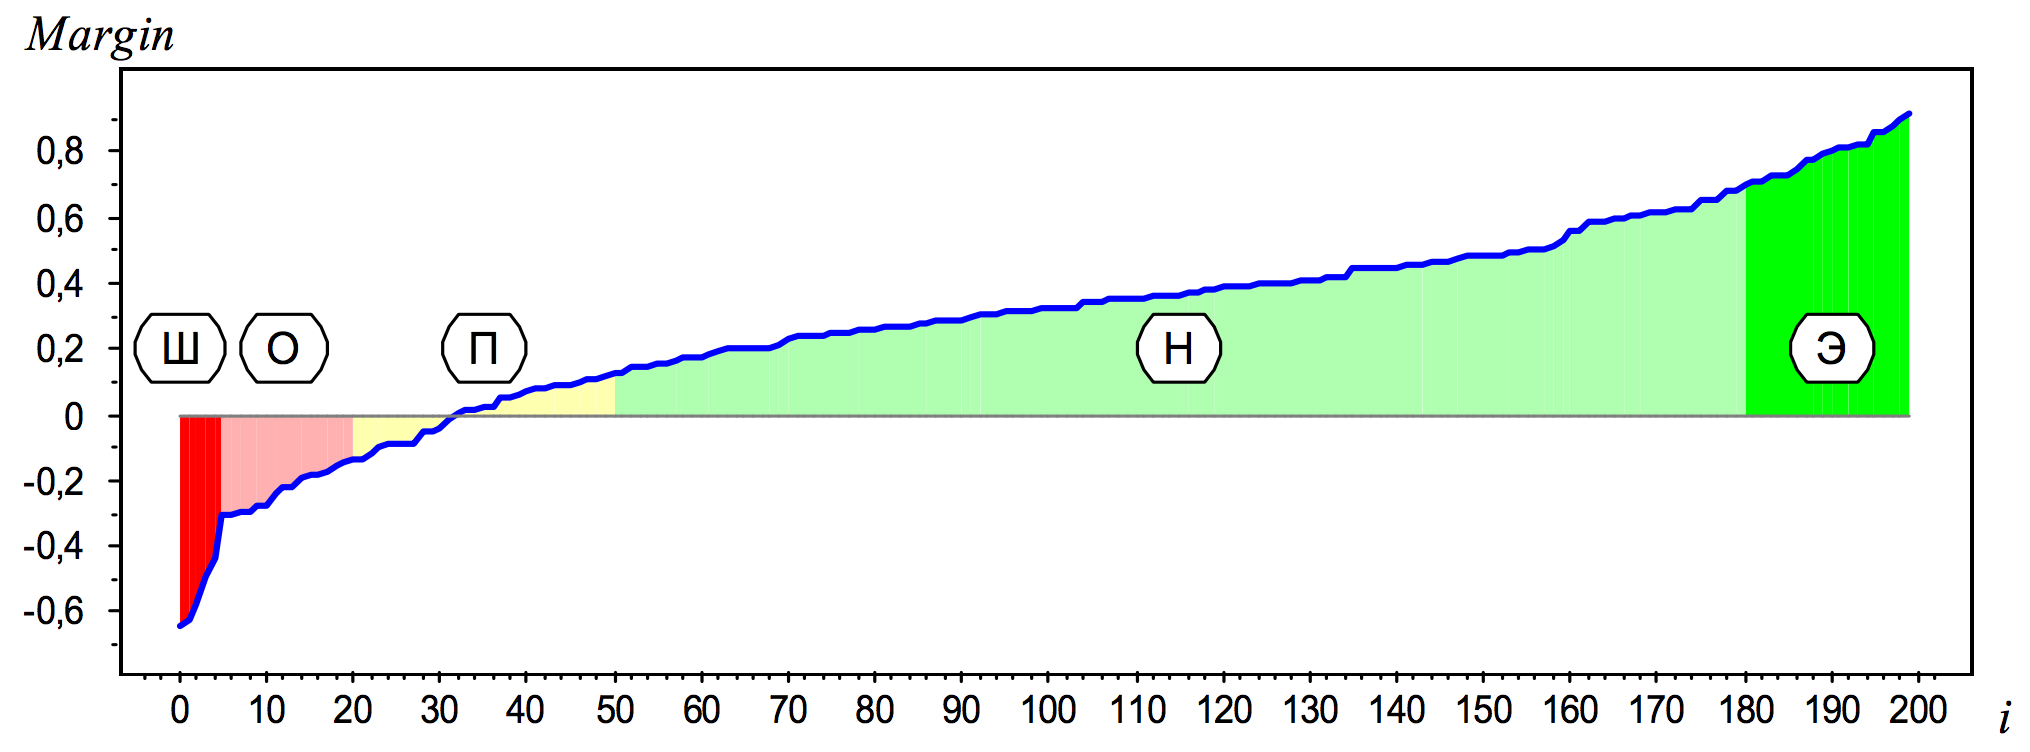

In [27]:
ip.Image("2.png", height=300)

In [28]:
neighbors_for_test = estimator.kneighbors(X_test, 10, return_distance=False)

In [29]:
counts = [np.bincount(x, minlength=10) for x in Y_train[neighbors_for_test]]

In [30]:
ideals = []
noise = []
for i, bincount in enumerate(counts):
    if bincount[Y_test[i]] == 0:
        noise.append(i)
    elif bincount[Y_test[i]] == 10:
        ideals.append(i)
        
print len(ideals), len(noise)

3735 45


### Noise:

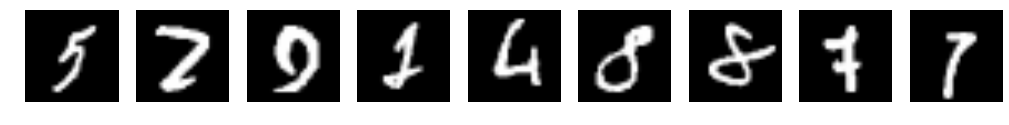

In [31]:
plot_grid(noise[9:18], 1, 9, dataset=X_test, im_size=28)

### Ideals:

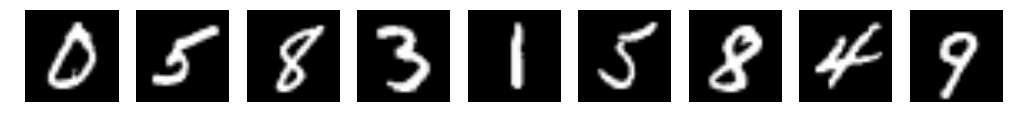

In [32]:
plot_grid(ideals[:9], 1, 9, dataset=X_test, im_size=28)

----
Bias-variance tradeoff for k-NN


$$ \mathrm{E}[(y - \hat{f}(x))^2] = \left( f(x) - \frac{1}{k}\sum_{i=1}^k f(N_i(x)) \right)^2 + \frac{\sigma^2}{k} + \sigma^2 $$

# Custom Metrics

Эвклидова метрика, не является единственно возможным способом вычисления расстояния. 
Чаще всего приходится подбирать метрики, поскольку качество работы классификатора зависит в основном от метрики.

Простым примером является классификация человека по зарплате и росту -- зарплата измеряется в тысячах рублей а рост в метрах, но при использовании эвклидовой метрики разница в 1 рубль в зарплате будет эквивалентна разнице в 1 метр в росте человека. Тогда расстояние между людьми будет определяться исключительно зарплатой, а рост будет играть роль только при условии равны зарплат.

In [35]:
from scipy.spatial.distance import cosine, euclidean, minkowski
x_exampe = X_test[10]

## Minkowski Distance

## $$p(x, x_i) = \left(\sum_{j} w_j \cdot |f_j(x) - f_j(x_i)| ^p \right) ^ {\frac{1}{p}}$$

## $w_i$ - веса признаков (нормировка)
## $~~f_j$ - возможно, нелинейное преобразование

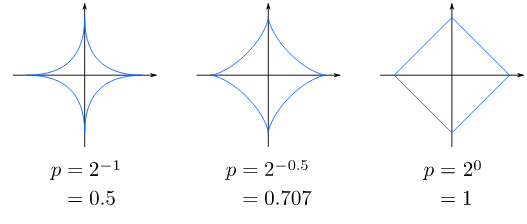

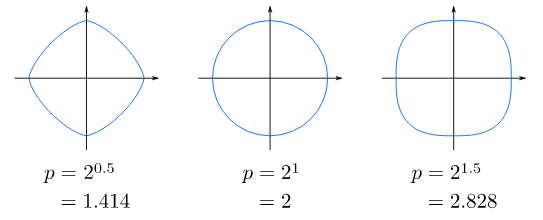

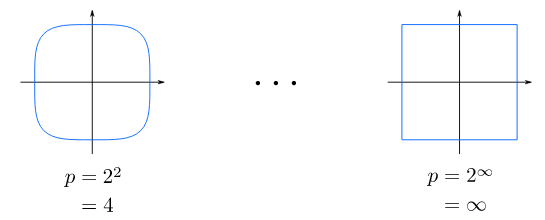

In [36]:
ip.display(ip.Image('img/1.png'), ip.Image('img/3.png'), ip.Image('img/2.png'))

Дисперсии весов уменьшаются с ростом p, даже при p=2 веса распределены нормально.

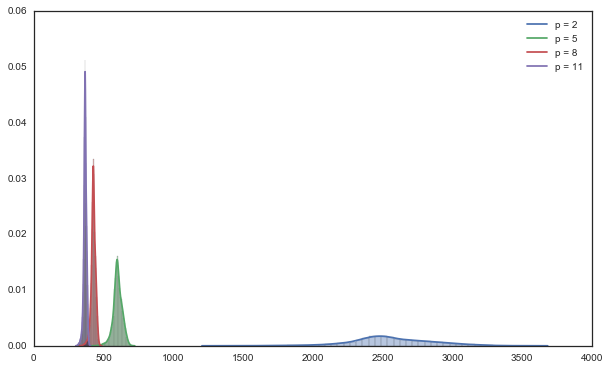

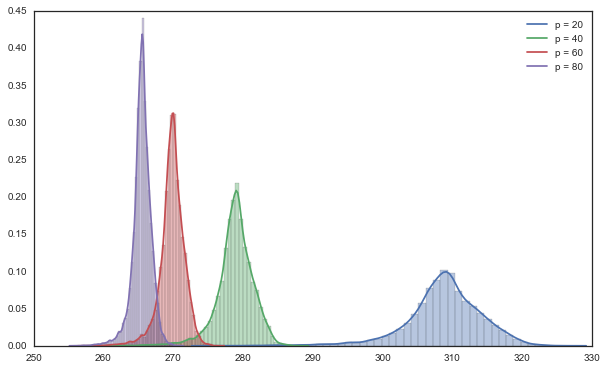

In [37]:
plt.figure(figsize=(10, 6))
for p in range(2, 12, 3):
    eucld_dists = [minkowski(x, x_exampe, p) for x in X_train]
    sns.distplot(eucld_dists, kde_kws={'label': 'p = %s' % p})
pylab.show()

plt.figure(figsize=(10, 6))
for p in range(20, 100, 20):
    eucld_dists = [minkowski(x, x_exampe, p) for x in X_train]
    sns.distplot(eucld_dists, kde_kws={'label': 'p = %s' % p})
pylab.show()

Можно сделать вывод, что дисперсия растояния между объектами уменьшается с ростом степени метрики -- все растояния примерно равны на высоких значениях p.

## Cosine Distance

## $$\text{similarity} = \cos(\theta) = {A \cdot B \over \|A\| \|B\|} = \frac{ \sum\limits_{i=1}^{n}{A_i \times B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{(A_i)^2}} \times \sqrt{\sum\limits_{i=1}^{n}{(B_i)^2}} }$$

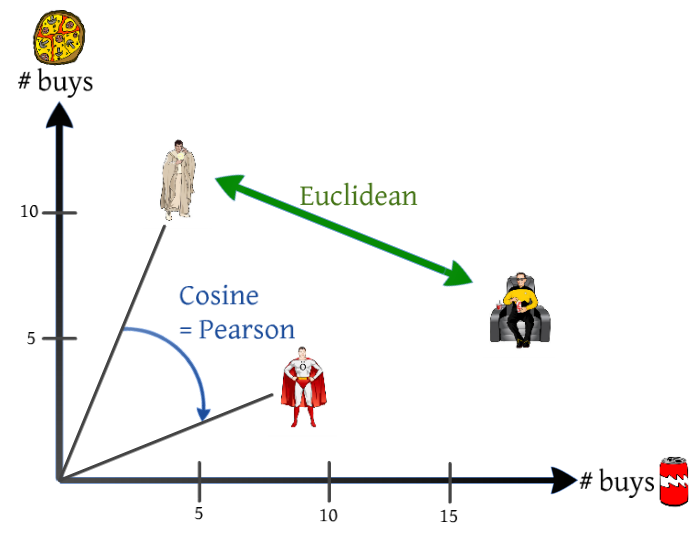

In [38]:
ip.Image('https://comsysto.files.wordpress.com/2013/02/euclidean_pearson_similarity.png')

Расстояния посчитанные с помощью косинусной меры имеют большую дисперсию -- веса соседей отличаются сильнее.

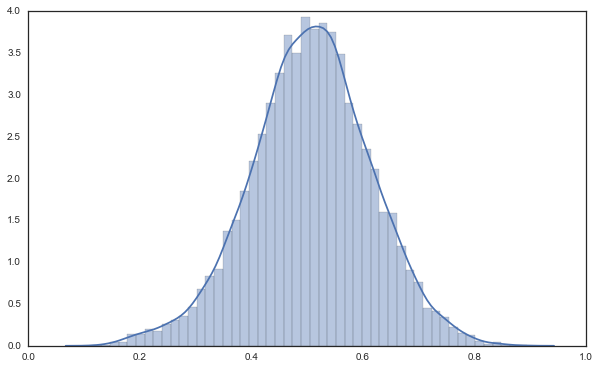

In [39]:
plt.figure(figsize=(10, 6))
cosin_dists = [cosine(x, x_exampe) for x in X_train]
sns.distplot(cosin_dists)

# Spaces, Dimension

------
Задачки

1. Рассмотрим единичный куб и куб с ребром длиной $ e, (e \leq 1) $ в пространстве размерности <b>D</b>. Каким должен быть $e$, чтобы малый куб занимал 1% от объема единичного куба? Рассмотрите случай, когда <b>D</b> равно 2, 10, 100.

2. Рассмотрим сферу радиуса r в пространстве размерности <b>D</b>. Какая часть объема находится между радиусоми r = 1 и $\hat r = 1-\epsilon$.

<img src="1.png" height="450" width="450">

- Качество метрического классификатора полностью определяется метрикой или пространством в котором находятся наши объекты. Неудачный выбор метрики или пространства приведет к низкому качеству классификации.
- Можно проецировать объекты из многомерного пространства на пространство меньшей размерности. К примеру для визуализации на двухмерное пространство.

!!! Исключительно с целью демонстрации бесстильности KNN перед плохим пространством 

Спроецируем объекты на двухмерное подпространство линейно и с сохранение специфичного расстояния.

## PCA

In [40]:
X_train, Y_train = X_train[:2000], Y_train[:2000]
X_test, Y_test = X_test[:2000], Y_test[:2000]

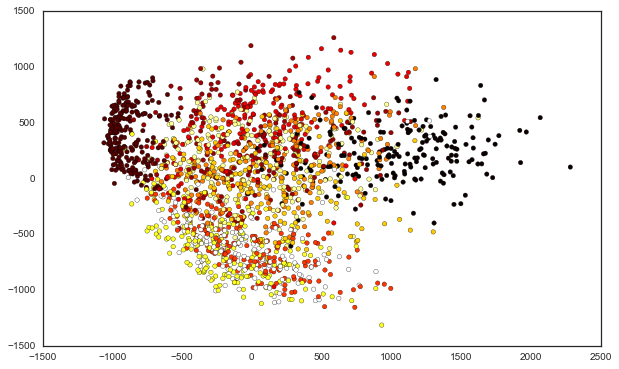

In [41]:
from sklearn.decomposition import RandomizedPCA

pca = RandomizedPCA(n_components=2)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
plt.figure(figsize=(10, 6))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train, cmap=cm.hot)

## TSNE

Laurens, Hinton Visualizing Data using t-SNE, 2008

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=200)

X_tsne = tsne.fit_transform(np.concatenate((X_train, X_test)))
X_train_tsne, X_test_tsne = X_tsne[:len(X_train)], X_tsne[len(X_train):]
plt.figure(figsize=(10, 6))

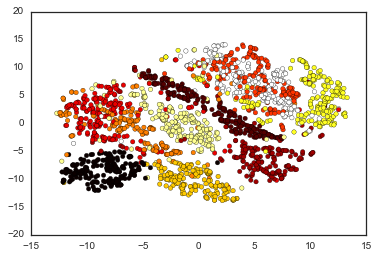

In [43]:
pylab.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=Y_train, cmap=cm.hot)

## KNN_PCA2d vs KNN_TSNE2d

In [44]:
knn_pca = KNeighborsClassifier().fit(X_train_pca, Y_train)
y_pca = knn_pca.predict(X_test_pca)
print 'knn pca accuracy_score = %s' % accuracy_score(y_pca, Y_test)

knn pca accuracy_score = 0.4115


In [45]:
knn_tsne = KNeighborsClassifier().fit(X_train_tsne, Y_train)
y_tsne = knn_tsne.predict(X_test_tsne)
print 'knn tsne accuracy_score = %s' % accuracy_score(y_tsne, Y_test)

knn tsne accuracy_score = 0.8685


Distance weightning.

In [ ]:
n_neighbors = 1500

In [ ]:
h = .02  # step size in the mesh

In [ ]:
for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    clf.fit(X_train_tsne, Y_train)
    
    print 'Accuracy = {0} with weghting scheme - {1}'.format(accuracy_score(clf.predict(X_test_tsne), Y_test), weights)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X_train_tsne[:, 0].min() - 1, X_train_tsne[:, 0].max() + 1
    y_min, y_max = X_train_tsne[:, 1].min() - 1, X_train_tsne[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap='Accent')

    # Plot also the training points
    plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=Y_train, cmap='viridis')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("10-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

# Implementation

## Distance Matrix

Подсчет матрицы расстояний каждого тестового и обучающего объекта.

|Resourse|Worst|
|-----|-----|-----|
|Space	|O($n^2$)|
|Naive Search	|O($n^2$)|
|Insert	|O(n)|
|Delete	|O(n)|

But 

- Two loop version took 48.485841 seconds
- One loop version took 35.695311 seconds
- No loop version took 3.518175 seconds

Как посчитать матрицу расстояний без циклов (метрика Эвклида)?

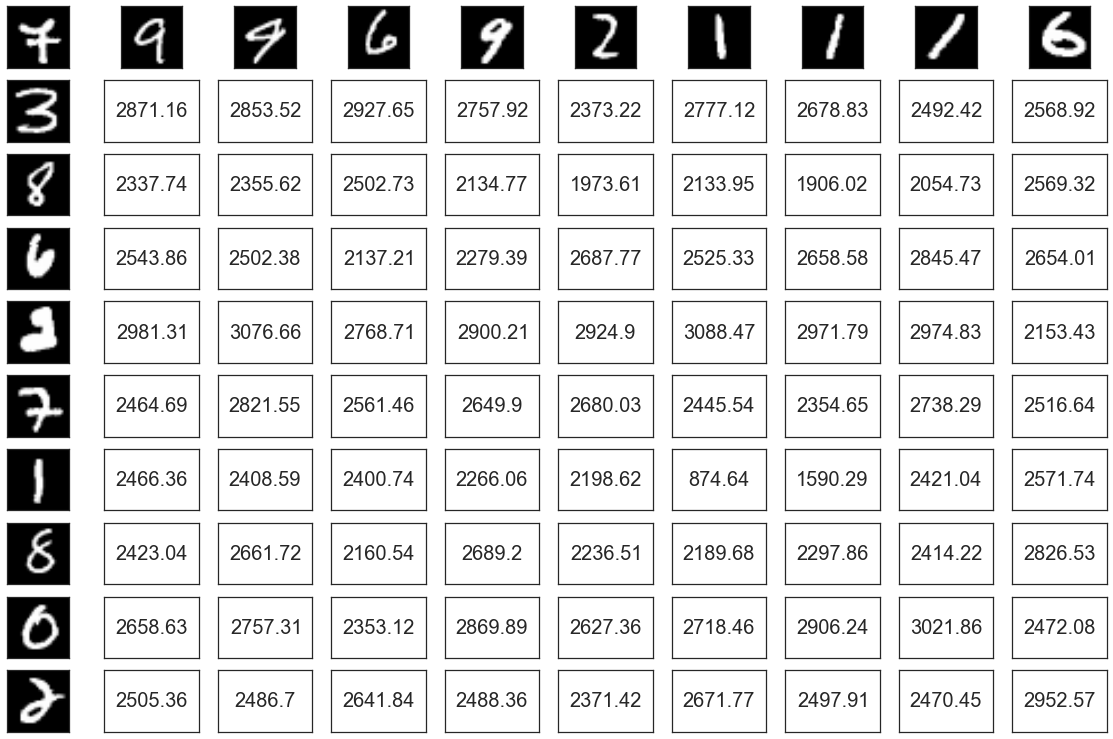

In [2]:
 ip.Image('img/dm.png', width=800)

## KDTree

Более применимыми на практике метрические деревья. Не требуют много памяти, быстрее производять поиск k ближайших соседей.

|Resourse|Average|Worst|
|-----|-----|-----|
|Space	|O(kn)	|O(n)|
|Search	|O(log kn)	|O(kn)|
|Insert	|O(log kn)	|O(kn)|
|Delete	|O(log kn)	|O(kn)|

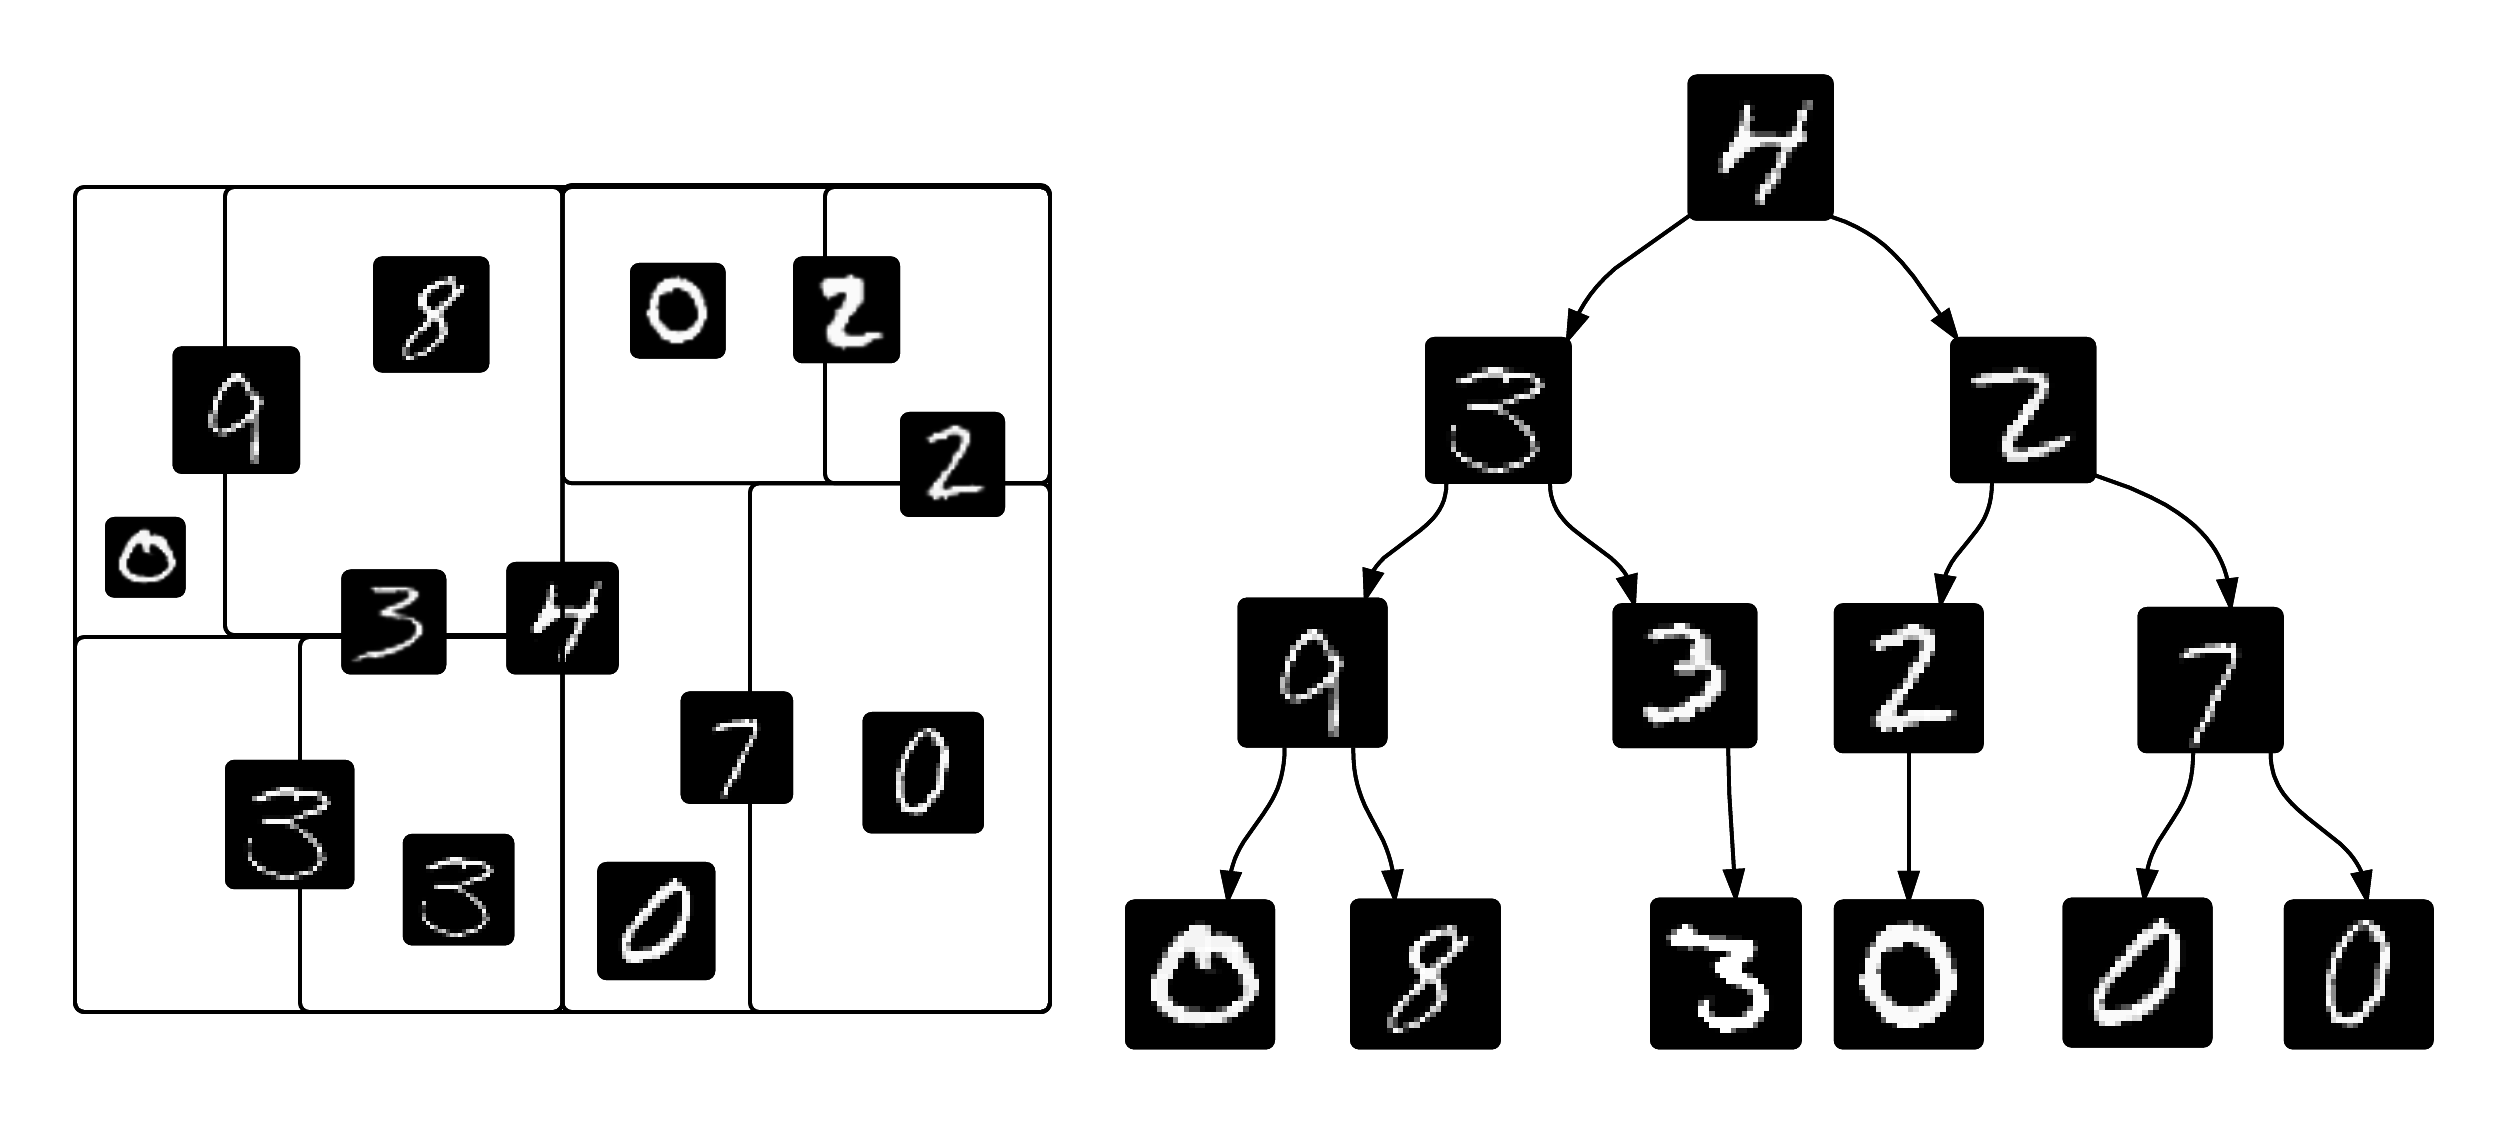

In [3]:
ip.Image('img/kdtree.png', width=800)

--------
<h2 align="center">Оптимизации для больших данных</h2> 

Создадим из доступных данных индекс с помощью Locality Sensitive Hashing и будем его использовать для быстрого поиска k ближайших соседей.

указание: увеличить объем train до 15000

In [ ]:
# Random index generator
rng = np.random.RandomState(42)

# Test data is used for queries
queries = X_test

# We use train data to build index
index_data = X_train

In [ ]:
# Metrics to collect for the plots
average_times_exact = []
average_times_approx = []
std_times_approx = []
accuracies = []
std_accuracies = []
average_speedups = []
std_speedups = []

In [ ]:
# Calculate the average query time
for n_samples in xrange(500, 15000, 500):
    X = index_data[:n_samples]
    # Initialize LSHForest for queries of a single neighbor
    lshf = LSHForest(n_estimators=20, n_candidates=200,
                     n_neighbors=10).fit(X)
    
    nbrs = NearestNeighbors(algorithm='brute', metric='cosine',
                            n_neighbors=10).fit(X)
    
    time_approx = []
    time_exact = []
    accuracy = []

    for i in range(20):
        # pick one query at random to study query time variability in LSHForest
        query = queries[[rng.randint(0, 5)]]

        t0 = time.time()
        exact_neighbors = nbrs.kneighbors(query, return_distance=False)
        time_exact.append(time.time() - t0)

        t0 = time.time()
        approx_neighbors = lshf.kneighbors(query, return_distance=False)
        time_approx.append(time.time() - t0)

        accuracy.append(np.in1d(approx_neighbors, exact_neighbors).mean())

    average_time_exact = np.mean(time_exact)
    average_time_approx = np.mean(time_approx)
    speedup = np.array(time_exact) / np.array(time_approx)
    average_speedup = np.mean(speedup)
    mean_accuracy = np.mean(accuracy)
    std_accuracy = np.std(accuracy)
   
    print("Index size: %d, exact: %0.3fs, LSHF: %0.3fs, speedup: %0.1f, "
          "accuracy: %0.2f +/-%0.2f" %
          (n_samples, average_time_exact, average_time_approx, average_speedup,
           mean_accuracy, std_accuracy))

    accuracies.append(mean_accuracy)
    std_accuracies.append(std_accuracy)
    average_times_exact.append(average_time_exact)
    average_times_approx.append(average_time_approx)
    std_times_approx.append(np.std(time_approx))
    average_speedups.append(average_speedup)
    std_speedups.append(np.std(speedup))

In [ ]:
# Plot average query time against n_samples
plt.figure()
plt.errorbar(range(500, 15000, 500), average_times_approx, yerr=std_times_approx,
             fmt='o-', c='r', label='LSHForest')

plt.plot(range(500, 15000, 500), average_times_exact, c='b',
         label="NearestNeighbors(algorithm='brute', metric='cosine')")

plt.legend(loc='upper left', fontsize='small')
plt.ylim(0, None)
plt.ylabel("Average query time in seconds")
plt.xlabel("n_samples")
plt.grid(which='both')
plt.title("Impact of index size on response time for first "
          "nearest neighbors queries")

In [ ]:
# Plot average query speedup versus index size
plt.figure()
plt.errorbar(range(500, 15000, 500), average_speedups, yerr=std_speedups,
             fmt='o-', c='r')
plt.ylim(0, None)
plt.ylabel("Average speedup")
plt.xlabel("n_samples")
plt.grid(which='both')
plt.title("Speedup of the approximate NN queries vs brute force")

In [ ]:
# Plot average precision versus index size
plt.figure()
plt.errorbar(range(500, 15000, 500), accuracies, std_accuracies, fmt='o-', c='c')
plt.ylim(0, 1.1)
plt.ylabel("precision@10")
plt.xlabel("n_samples")
plt.grid(which='both')
plt.title("precision of 10-nearest-neighbors queries with index size")

plt.show()

<h1 align="center">CIFAR10 Dataset</h1> 

In [63]:
from data_utils import load_CIFAR10
pylab.rcParams['figure.figsize'] = (10.0, 8.0) 

In [64]:
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

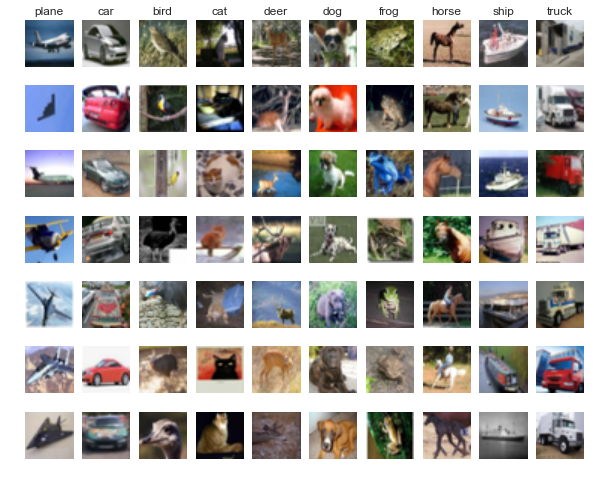

In [65]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [66]:
num_training, num_test = 10000, 500

X_train, y_train = X_train[:num_training], y_train[:num_training]
X_test, y_test = X_test[:num_test], y_test[:num_test]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [67]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print 'accuracy_score = %s' % accuracy_score(y_pred, y_test)

accuracy_score = 0.324


In [ ]:
# In MNIST dataset we have accuracy_score ~ 0.90+ out of box.

<h1 align="center">Summary: Advantages and Disadvantages</h1> 

- Метрические классификаторы — одни из самых простых. 
- Качество классификации определяется качеством метрики или пространства.
- Что можно обучать:
    - число ближайших соседей k или ширину окна;
    - веса объектов;
    - набор эталонов (prototype selection);
    - метрику (distance learning, similarity learning);
    - веса признаков.
- Метрические классификаторы требуют хранить всю выборку, время предсказания $log(n)$ от размера обучающей выборки. 
- Распределение отступов делит объекты на эталонные, неинформативные, пограничные, ошибки и выбросы.

<h1 align="center">References</h1> 

- KNN http://www.machinelearning.ru/wiki/images/c/c3/Voron-ML-Metric-slides.pdf
- ESL https://web.stanford.edu/~hastie/local.ftp/Springer/OLD/ESLII_print4.pdf
- TSNE http://www.youtube.com/watch?v=RJVL80Gg3lA